# Plotting the geodesics using Krang package for a finite observer

### Import Krang branch
Import the krang `finite-observer` in Krang.jl rep (https://github.com/dominic-chang/Krang.jl/tree/finite-observer). 

`using Pkg`

`Pkg.add(url = "https://github.com/orgname/reponame.git", rev = "branch_name")`


### Setup the plotting settings

In [673]:
import GLMakie as GLMk
GLMk.Makie.inline!(true)

curr_theme = GLMk.Theme(# Makie theme
    fontsize=20,
    Axis=(
        xticksvisible=false,
        xticklabelsvisible=false,
        yticksvisible=false,
        yticklabelsvisible=false,
        leftspinevisible=false,
        rightspinevisible=false,
        topspinevisible=false,
        bottomspinevisible=false,
        titlefontsize=30,
    ),
)

GLMk.set_theme!(GLMk.merge(curr_theme, GLMk.theme_latexfonts()))


### Necessary Parameters:
- `metric`: Kerr metric with a certain spin `a`
- `θo`: Observer inclination angle in radians
- `res`: Amount of pixels in a single row. The final image has `res^2` pixels/geodesics.
- `ro`: Observer radius
- `radfovx`: Field of view of the camera in the x-direction in radians. It can be calculated as atan(dx/r0)
- `radfovy`: Field of view of the camera in the y-direction in radians. It can be calculated as atan(dy/r0)
- `geopoints`: Number of points the geodesic will span using mino time as the affine parameter

In [ ]:
using Krang
a_krang = 0.9
metric = Krang.Kerr(a_krang);
θo = 45* π / 180;
res = 2
ro = 1000.0
radfovx = 7.5/1000
radfovy = 7.5/1000
geopoints = 1000

1000

In [813]:
    camera = Krang.IntensityCamera(metric, θo, ro,-radfovx, radfovx, -radfovy, radfovy, res);
    #camera = Krang.IntensityCamera(metric, θo, -5.0,5.0, -5.0, 5.0, res);
    lines = Krang.generate_ray.(camera.screen.pixels, geopoints)
    println("Number of rays: ", length(lines))

Number of rays: 4


Number of points in ray: 998
Number of points in ray: 998
Number of points in ray: 998
Number of points in ray: 998


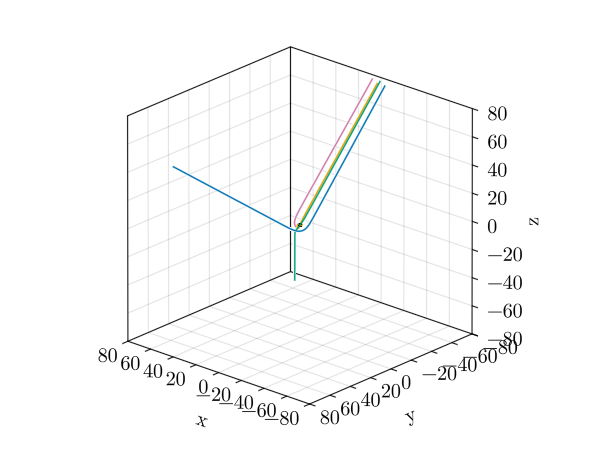

In [814]:
fig = GLMk.Figure()
ax = GLMk.Axis3(fig[1,1], aspect=(1,1,1), azimuth = 40)
scale = 80
GLMk.xlims!(ax, (-scale, scale))
GLMk.ylims!(ax, (-scale, scale))
GLMk.zlims!(ax, (-scale, scale))

sphere = GLMk.Sphere(GLMk.Point(0.0,0.0,0.0), horizon(metric))
GLMk.mesh!(ax, sphere, color=:black) # Sphere to represent black hole

for i in lines
    pts = [GLMk.Point3f(
        p.rs * sin(p.θs) * cos(p.ϕs),
        p.rs * sin(p.θs) * sin(p.ϕs),
        p.rs * cos(p.θs)
    ) for p in i if p.rs >= horizon(metric)]
    println("Number of points in ray: ", length(pts))

    GLMk.lines!(ax, pts)
end

fig



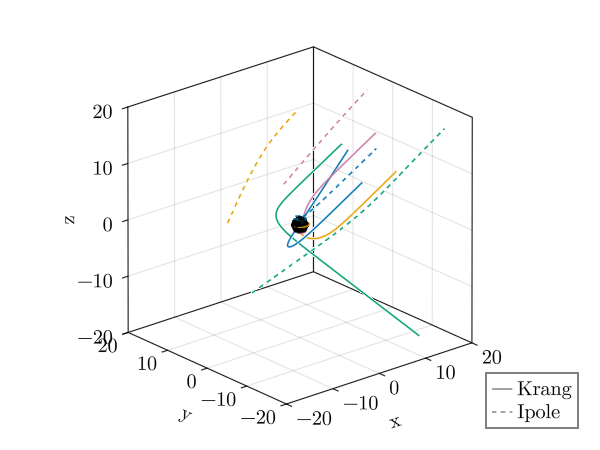

In [815]:
fig = GLMk.Figure()
ax = GLMk.Axis3(fig[1,1], aspect=(1,1,1))
scale = 20
GLMk.xlims!(ax, (-scale, scale))
GLMk.ylims!(ax, (-scale, scale))
GLMk.zlims!(ax, (-scale, scale))

sphere = GLMk.Sphere(GLMk.Point(0.0,0.0,0.0), horizon(metric))
GLMk.mesh!(ax, sphere, color=:black) # Sphere to represent black hole

# Generate a color for each pixel
# Wong colors only has 7 colors, so cycle through them using mod1(i, 7)
colors = [GLMk.Makie.wong_colors()[mod1(i, 7)] for i in 1:(res*res)]

# Plot Krang rays (solid)
for (idx, i) in enumerate(lines)
    pts = [GLMk.Point3f(
        p.rs * sin(p.θs) * cos(p.ϕs),
        p.rs * sin(p.θs) * sin(p.ϕs),
        p.rs * cos(p.θs)
    ) for p in i if p.rs >= horizon(metric)]
    GLMk.lines!(ax, pts, color=colors[idx], linestyle=:solid)
end

# Plot Ipole rays (dashed)
for i in 1:res, j in 1:res
    idx = (i-1)*res + j
    traj = trajectory[i, j]
    pts = [
        begin
            r = bl_coord(t.X)[1]
            th = bl_coord(t.X)[2]
            phi = t.X[4]
            GLMk.Point3f(
                r * sin(th) * cos(phi),
                r * sin(th) * sin(phi),
                r * cos(th)
            )
        end
        for t in traj if bl_coord(t.X)[1] >= horizon(metric)
    ]
    GLMk.lines!(ax, pts, color=colors[idx], linestyle=:dash)
end

# Add legend
GLMk.lines!(ax, [GLMk.Point3f(0,0,0), GLMk.Point3f(1,0,0)], color=:gray, linestyle=:solid, label="Krang")
GLMk.lines!(ax, [GLMk.Point3f(0,0,0), GLMk.Point3f(1,0,0)], color=:gray, linestyle=:dash, label="Ipole")
GLMk.axislegend(ax, position=:rb)

fig

## Plotting it from Jipole's RK2 Integrator

### Defining parameters:
- `ro`: radial position of the observer
- `th`: theta position of the observer
- `phi`: phi position of the observer

In [800]:
#Setting up the parameters
ro = 1000.0
th = 45.0
phi = -90.0
radfovx = 30/1000
radfovy = 30/1000
res = 2
eps_ipole = 0.01
freq = freqcgs * HPL/(ME * CL * CL) 


1.8614589389997047e-9

In [801]:
include("../src/main.jl")
Xcamera = camera_position(ro, th, phi)

trajectory = IpoleGeoIntensityIntegration(Xcamera, radfovx, radfovy, freq, eps_ipole, maxnstep, res, 0; integrate_emission_flag=false )

Processing row 0 out of 2


Processing row 1 out of 2


2×2 Matrix{Vector{OfTraj}}:
 [OfTraj(3.2307e21, [0.0, 6.90776, 0.25, -1.5708], [1.50804e-29, 1.50202e-32, 0.0, 1.35724e-35], [0.0, 6.90776, 0.25, -1.5708], [1.50804e-29, 1.50202e-32, 0.0, 1.35724e-35]), OfTraj(3.1984e21, [-10.0312, 6.89771, 0.25, -1.57081], [1.5081e-29, 1.51718e-32, 1.99301e-41, 1.38482e-35], [-5.01551, 6.90276, 0.25, -1.5708], [1.50807e-29, 1.50952e-32, 9.67293e-42, 1.37082e-35]), OfTraj(3.16642e21, [-19.9625, 6.88767, 0.25, -1.57081], [1.50816e-29, 1.53249e-32, 4.08737e-41, 1.41296e-35], [-14.9968, 6.89272, 0.25, -1.57081], [1.50813e-29, 1.52476e-32, 3.00978e-41, 1.39868e-35]), OfTraj(3.13475e21, [-29.7949, 6.87763, 0.25, -1.57082], [1.50822e-29, 1.54795e-32, 6.28699e-41, 1.44168e-35], [-24.8786, 6.88268, 0.25, -1.57082], [1.50819e-29, 1.54014e-32, 5.15554e-41, 1.42711e-35]), OfTraj(3.10341e21, [-39.5294, 6.86759, 0.25, -1.57083], [1.50829e-29, 1.56357e-32, 8.59594e-41, 1.47098e-35], [-34.6621, 6.87264, 0.25, -1.57083], [1.50826e-29, 1.55568e-32, 7.40855e-41, 1.45611

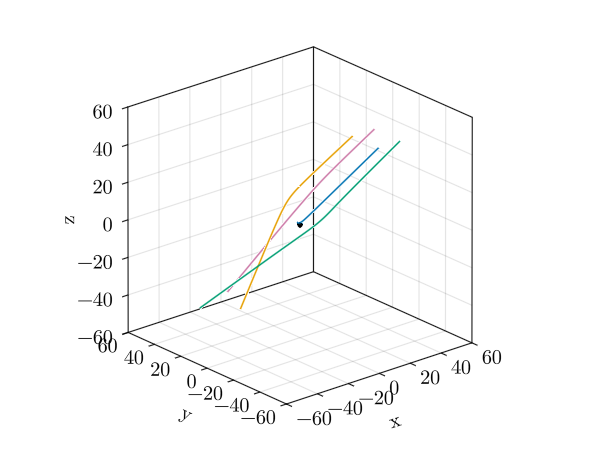

In [802]:
fig = GLMk.Figure()
ax = GLMk.Axis3(fig[1,1], aspect=(1,1,1))
scale = 60
GLMk.xlims!(ax, (-scale, scale))
GLMk.ylims!(ax, (-scale, scale))
GLMk.zlims!(ax, (-scale, scale))
sphere = GLMk.Sphere(GLMk.Point(0.0,0.0,0.0), horizon(metric))
GLMk.mesh!(ax, sphere, color=:black) # Sphere to represent black hole

for i in 1:res, j in 1:res
    traj = trajectory[i, j]
    pts = [
        begin
            r = bl_coord(t.X)[1]
            th = bl_coord(t.X)[2]
            phi = t.X[4]
            GLMk.Point3f(
                r * sin(th) * cos(phi),
                r * sin(th) * sin(phi),
                r * cos(th)
            )
        end
        for t in traj if bl_coord(t.X)[1] >= horizon(metric)
    ]
    GLMk.lines!(ax, pts)
end

fig

### Plot both Krang and Ipole in lines in the same plot, the color of the rays from each pixel should match

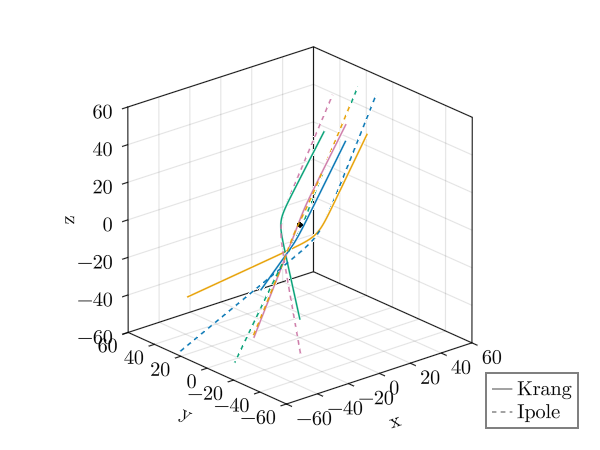

In [652]:
fig = GLMk.Figure()
ax = GLMk.Axis3(fig[1,1], aspect=(1,1,1))
scale = 60
GLMk.xlims!(ax, (-scale, scale))
GLMk.ylims!(ax, (-scale, scale))
GLMk.zlims!(ax, (-scale, scale))

sphere = GLMk.Sphere(GLMk.Point(0.0,0.0,0.0), horizon(metric))
GLMk.mesh!(ax, sphere, color=:black) # Sphere to represent black hole

# Generate a color for each pixel
# Wong colors only has 7 colors, so cycle through them using mod1(i, 7)
colors = [GLMk.Makie.wong_colors()[mod1(i, 7)] for i in 1:(res*res)]

# Plot Krang rays (solid)
for (idx, i) in enumerate(lines)
    pts = [GLMk.Point3f(
        p.rs * sin(p.θs) * cos(p.ϕs),
        p.rs * sin(p.θs) * sin(p.ϕs),
        p.rs * cos(p.θs)
    ) for p in i if p.rs >= horizon(metric)]
    GLMk.lines!(ax, pts, color=colors[idx], linestyle=:solid)
end

# Plot Ipole rays (dashed)
for i in 1:res, j in 1:res
    idx = (i-1)*res + j
    traj = trajectory[i, j]
    pts = [
        begin
            r = bl_coord(t.X)[1]
            th = bl_coord(t.X)[2]
            phi = t.X[4]
            GLMk.Point3f(
                r * sin(th) * cos(phi),
                r * sin(th) * sin(phi),
                r * cos(th)
            )
        end
        for t in traj if bl_coord(t.X)[1] >= horizon(metric)
    ]
    GLMk.lines!(ax, pts, color=colors[idx], linestyle=:dash)
end

# Add legend
GLMk.lines!(ax, [GLMk.Point3f(0,0,0), GLMk.Point3f(1,0,0)], color=:gray, linestyle=:solid, label="Krang")
GLMk.lines!(ax, [GLMk.Point3f(0,0,0), GLMk.Point3f(1,0,0)], color=:gray, linestyle=:dash, label="Ipole")
GLMk.axislegend(ax, position=:rb)

fig